In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test_images', 'train.csv', 'sample_submission.csv', 'train_images']


In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CosineSimilarity
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models
from pathlib import Path
import PIL.Image
import random
import math
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
path = Path('../input')

In [4]:
tr_df = pd.read_csv(path/'train.csv')

In [5]:
va_ratio = 0.05

In [6]:
tr_df, va_df = train_test_split(tr_df, 
#                                 train_size=0.05,
                                test_size=va_ratio, 
                                random_state=42, 
                                stratify=tr_df['diagnosis'])

In [7]:
# From https://www.kaggle.com/taindow/pre-processing-train-and-test-images

import os
import glob
import cv2
import numpy as np
import PIL

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(img)

In [8]:
class APTOSDataset(Dataset):
    def __init__(self, path, df, labels=None):
        self.len = len(df)
        self.path = path
        self.labels = labels
        self.images = list(map(lambda f: path/(f + '.png'), df['id_code']))
        self.trfms = transforms.Compose([
            transforms.Resize(240),
            transforms.CenterCrop(240),
            #     transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            ])
        
    def __getitem__(self, index):
        if self.labels is not None:
            label = self.labels[index]
        else:
            label = 0
        path = self.images[index]
        return self.trfms(circle_crop(str(path))), label
    
    def __len__(self):
        return self.len

In [9]:
tr_ds = APTOSDataset(path/'train_images', tr_df, tr_df['diagnosis'].values)

In [10]:
va_ds = APTOSDataset(path/'train_images', va_df, va_df['diagnosis'].values)

In [11]:
len(tr_ds), len(va_ds)

(3478, 184)

In [12]:
bs = 16
nw = 2

In [13]:
tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True, shuffle=True)

In [14]:
va_dl = DataLoader(va_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True, shuffle=True)

In [15]:
class ArcMarginProduct(nn.Module):
    def __init__(self, s=32.0, m=0.50, easy_margin=True):
        super(ArcMarginProduct, self).__init__()
        self.s = s
        self.m = m

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, cosine, label):
        # cos(theta + m)
#         cosine = torch.clamp(cosine, -1.0, 1.0)
#         print("cos:", cosine)#, cosine >= 1., cosine <= -1.)
#         assert(not (cosine.clone().detach().cpu().numpy() >= 1.).any())
#         assert(not (cosine.clone().detach().cpu().numpy() <= -1.).any())
#         sine_2 = F.relu(1.0 - torch.pow(cosine, 2))
#         print(sine_2)#, sine_2 > 1.0)
#         assert(not (sine_2.detach().cpu().numpy() > 1.0).any())
#         sine = torch.sqrt(sine_2)
#         sine = torch.clamp(sine, -1.0, 1.0)
#         print("sin:", sine)#, sine >= 1., sine <= -1.)
#         assert(not (sine.clone().detach().cpu().numpy() >= 1.).any())
#         assert(not (sine.clone().detach().cpu().numpy() <= -1.).any())
#         phi = cosine * self.cos_m - sine * self.sin_m
        phi = cosine - self.m

#         if self.easy_margin:
#             phi = torch.where(cosine > 0, phi, cosine)
#         else:
#             phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        
        output = F.cross_entropy(output, label)
#         print("loss:", output)
        return output

In [16]:
class CosineEmbedding(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CosineEmbedding, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)
        
    def forward(self, inputs):
#         print("emb weight:", self.weight)
#         print("inp:", inputs)
        return F.linear(F.normalize(inputs), F.normalize(self.weight))
#         return F.linear(inputs, self.weight)

    def normalize(self):
#         return
        with torch.no_grad():
            torch.div(self.weight, self.weight.norm(p=None, dim=1, keepdim=True), out=self.weight)


In [17]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 45770392.24it/s]


In [18]:
embedding_dim = 2
num_classes = 5

In [19]:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(),
#     nn.Linear(in_features=512, out_features=num_classes, bias=True))
    nn.Linear(in_features=512, out_features=embedding_dim, bias=False))
# model.fc = nn.Linear(in_features=512, out_features=embedding_dim, bias=False)
model.cuda();

In [20]:
embedding = CosineEmbedding(embedding_dim, num_classes)
embedding.cuda();

In [21]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [22]:
criterion = ArcMarginProduct(s=16.0, m=0.0)

In [23]:
lr = 1e-2
optimizer = Adam(model.fc.parameters(), lr=lr)
optimizer.add_param_group({'params': embedding.parameters(), 'lr': lr})

In [24]:
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

In [25]:
num_epochs = 10
model_dir = Path('/kaggle/working/')

In [26]:
tr_metrics = []
va_metrics = []

In [27]:
for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    print('Epoch: {:02d}\n'.format(epoch))
    
    iterations = 0
    running_loss = 0.0
    running_acc = 0.0
    running_ce = 0.0
    model.train()
    for inputs, targets in tqdm(tr_dl):
#     for inputs, targets in tr_dl:
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = embedding(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        embedding.normalize()
        optimizer.step()
        
        loss = loss.item()
        running_loss += loss
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == targets.data, dtype=torch.float32) / inputs.shape[0]
        running_acc += acc
        ce = F.cross_entropy(outputs, targets).mean().item()
        running_ce += ce
        tr_metrics.append((loss, acc, ce))
        iterations += 1
    
    tr_loss = running_loss / iterations
    tr_acc = running_acc / iterations
    tr_ce = running_ce / iterations
    print('Train: Loss: {:.6f} Acc: {:.6f} CE: {:.6f}'.format(tr_loss, tr_acc, tr_ce))
    
    iterations = 0
    running_loss = 0.0
    running_ce = 0.0
    running_acc = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(va_dl):
#         for inputs, targets in va_dl:
            inputs = inputs.cuda()
            targets = targets.cuda()
            outputs = model(inputs)
            outputs = embedding(outputs)
            
            loss = criterion(outputs, targets)
            loss = loss.item()
            running_loss += loss
            _, preds = torch.max(outputs, 1)
#             print(preds, targets.data)
            acc = torch.sum(preds == targets.data, dtype=torch.float32) / inputs.shape[0]
#             print(acc)
            running_acc += acc
            running_ce += F.cross_entropy(outputs, targets).mean().item()
            iterations += 1
            
    va_loss = running_loss / iterations
    va_acc = running_acc / iterations
    va_ce = running_ce / iterations
    va_metrics.append((va_loss, va_acc, va_ce))
    print('Val: Loss: {:.6f} Acc: {:.6f} CE: {:.6f}'.format(va_loss, va_acc, va_ce))
#     print(embedding.weight)
    scheduler.step()

Epoch: 00



Train: Loss: 1.890606 Acc: 0.599366 CE: 1.452383


Val: Loss: 0.880113 Acc: 0.750000 CE: 1.425345
Epoch: 01



Train: Loss: 0.936916 Acc: 0.699309 CE: 1.443903


Val: Loss: 0.931220 Acc: 0.704545 CE: 1.474190
Epoch: 02



Train: Loss: 0.903795 Acc: 0.685484 CE: 1.456309


Val: Loss: 0.862158 Acc: 0.721591 CE: 1.444639
Epoch: 03



Train: Loss: 0.857427 Acc: 0.705645 CE: 1.448611


Val: Loss: 0.886429 Acc: 0.721591 CE: 1.442428
Epoch: 04



Train: Loss: 0.823797 Acc: 0.706797 CE: 1.442188


Val: Loss: 0.864726 Acc: 0.727273 CE: 1.443351
Epoch: 05



Train: Loss: 0.815384 Acc: 0.710829 CE: 1.439848


Val: Loss: 0.856341 Acc: 0.727273 CE: 1.429440
Epoch: 06



Train: Loss: 0.828157 Acc: 0.712846 CE: 1.439517


Val: Loss: 0.855653 Acc: 0.721591 CE: 1.424781
Epoch: 07



Train: Loss: 0.824555 Acc: 0.700749 CE: 1.438180


Val: Loss: 0.836875 Acc: 0.721591 CE: 1.432615
Epoch: 08



Train: Loss: 0.828962 Acc: 0.714574 CE: 1.441888


Val: Loss: 0.825211 Acc: 0.744318 CE: 1.422705
Epoch: 09



Train: Loss: 0.811901 Acc: 0.720046 CE: 1.437789


Val: Loss: 0.765097 Acc: 0.750000 CE: 1.418548



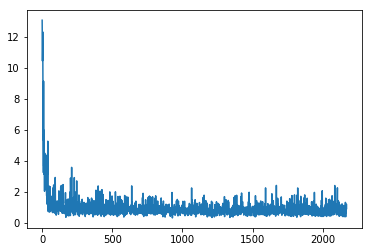

In [28]:
plt.plot(list(map(lambda t:t[0], tr_metrics)))

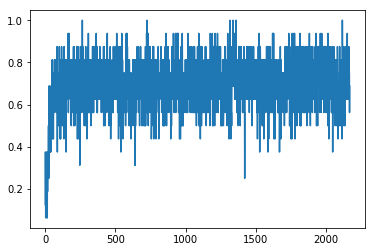

In [29]:
plt.plot(list(map(lambda t:t[1], tr_metrics)))

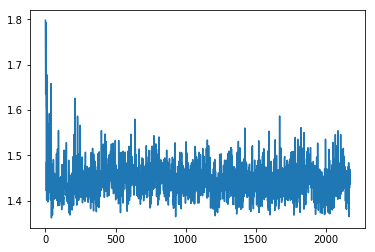

In [30]:
plt.plot(list(map(lambda t:t[2], tr_metrics)))

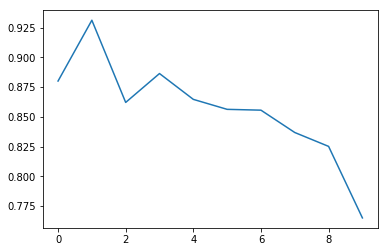

In [31]:
plt.plot(list(map(lambda t:t[0], va_metrics)))

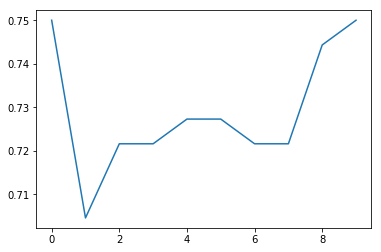

In [32]:
plt.plot(list(map(lambda t:t[1], va_metrics)))

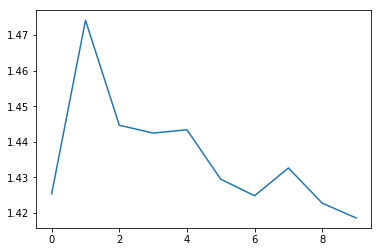

In [33]:
plt.plot(list(map(lambda t:t[2], va_metrics)))